In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)  # 设置 matplotlib 日志级别为 WARNING
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

matplotlib.rcParams['font.family']= ['Songti SC']  # 使用黑体-简
matplotlib.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

2025-03-27 21:19:08.265613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv('../data/train.csv', parse_dates=True)
df.head()

,date,open,close,low,high,volume,count,amount,EMA20,EMA100,...,close_volatility,Volatility_10,close_Volume_volatility,Volume_volatility_10,UpperBB,MiddleBB,LowerBB,return_lag1,return_lag3,return_lag5
0,2017-10-28 13:30:00,292.37,292.74,292.37,292.75,160.682134,20.0,0.5489,294.090399,294.843200,...,0.001299,0.016358,0.208714,20.221269,298.296695,294.6315,290.966305,0.001300,0.001437,-0.007560
1,2017-10-28 14:00:00,292.73,291.96,291.86,292.75,176.740890,22.0,0.6049,293.887504,294.786107,...,-0.002668,0.013005,-0.471551,2.280677,298.160943,294.4110,290.661057,-0.002664,-0.002630,-0.002562
2,2017-10-28 14:30:00,291.97,292.91,291.20,294.59,234.267629,22.0,0.8014,293.794408,294.748956,...,0.003249,0.013102,0.761039,2.320067,297.903752,294.2305,290.557248,0.003254,0.001881,0.002018
3,2017-10-28 15:00:00,292.94,292.94,291.29,294.58,133.953471,21.0,0.4573,293.713036,294.713135,...,0.000102,0.012696,0.013719,2.177855,297.630285,294.0575,290.484715,0.000102,0.000683,0.000717
4,2017-10-28 15:30:00,292.89,292.87,291.20,292.89,271.680139,23.0,0.9288,293.632747,294.676638,...,-0.000239,0.009353,-0.064928,1.628303,297.295646,293.8750,290.454354,-0.000239,0.003117,0.001744


In [4]:
target ='close'
features = df.drop(columns=['date', target]).values
X = features.copy()
y = df[target].copy().values.reshape(-1, 1)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X)
y_train_scaled = scaler_y.fit_transform(y)

In [5]:
# 创建输入序列和标签，使用滑动窗口
def create_sequneces(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

lstm_params={"layers":2, 'units': 64,  'dropout_rate': 0.3, 'learning_rate': 0.0001, 'clipvalue': 0.5, 'epochs': 20,'batch_size': 64, 'input_window': 120}
layers = lstm_params.get('layers')
model_name=f"LSTM-w{lstm_params.get('input_window')}-layers{layers}-u{lstm_params.get('units')}-d{lstm_params.get('dropout_rate')}-l{lstm_params.get('learning_rate')}-c{lstm_params.get('clipvalue')}-e{lstm_params.get('epochs')}-b{lstm_params.get('batch_size')}"
X_train, y_train = create_sequneces(X_train_scaled, y_train_scaled)

In [6]:
print("划分数据集...")
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42, shuffle=False)
X_val,X_test, y_val,y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=False)

划分数据集...


In [7]:
print("构建LSTM模型...")
print(f"输入数据形状检查：{X_train.shape}")  # 应为 (样本数, 时间步, 特征数)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=lstm_params.get('units'), 
                               input_shape=( X_train.shape[1], X_train.shape[2]), return_sequences=layers > 1))
model.add(tf.keras.layers.Dropout(lstm_params.get('dropout_rate')))
for i in range(1, lstm_params.get('layers')):
    print(f"增加一层layer = {i+1}, return_sequences={layers -1 > i}")
    model.add(tf.keras.layers.LSTM(units=lstm_params.get('units'), return_sequences=(layers -1 > i)))
    model.add(tf.keras.layers.Dropout(lstm_params.get('dropout_rate')))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= lstm_params.get('learning_rate'),
                                                 clipvalue=lstm_params.get('clipvalue')), loss='mean_squared_error', metrics=['mae'])
model.summary()

构建LSTM模型...
输入数据形状检查：(39212, 24, 30)
增加一层layer = 2, return_sequences=False


/opt/anaconda3/envs/python312/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        24,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,409 (224.25 KB)

 Trainable params: 57,409 (224.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
print("训练模型...")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=lstm_params.get('epochs'), 
                    batch_size=lstm_params.get('batch_size'), 
                    validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

训练模型...
Epoch 1/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.0089 - mae: 0.0608 - val_loss: 1.7532e-05 - val_mae: 0.0032
Epoch 2/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.0013 - mae: 0.0251 - val_loss: 2.9926e-05 - val_mae: 0.0046
Epoch 3/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 9.5371e-04 - mae: 0.0205 - val_loss: 2.2639e-05 - val_mae: 0.0040
Epoch 4/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 7.8202e-04 - mae: 0.0181 - val_loss: 1.4426e-05 - val_mae: 0.0027
Epoch 5/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 7.2425e-04 - mae: 0.0167 - val_loss: 2.2701e-05 - val_mae: 0.0039
Epoch 6/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 6.2431e-04 - mae: 0.0153 - val_loss: 5.2952e-05 - val_mae: 0.0067
Epoch 7/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 5.7477e-04 - mae: 0.0143 - val_loss: 1.7371e-05 - val_mae: 0.0035
Epoch 8/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 5.2822e-04 - mae: 0.0136 - val_loss: 1.292

In [9]:
print("预测模型...")
predictions = model.predict(X_test)
predicted_prices =  scaler_y.inverse_transform(predictions)
real_prices = scaler_y.inverse_transform(y_test.reshape(-1, 1))

预测模型...
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


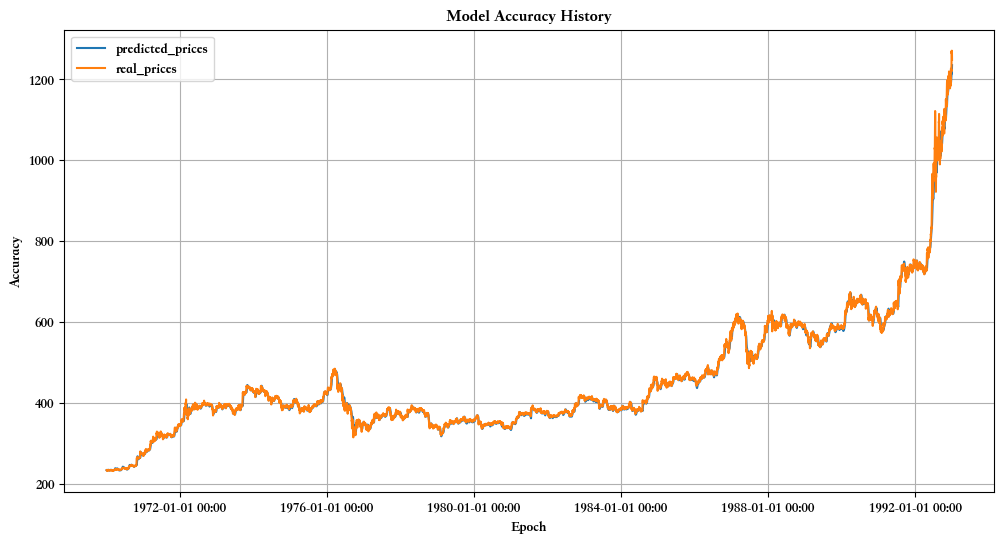

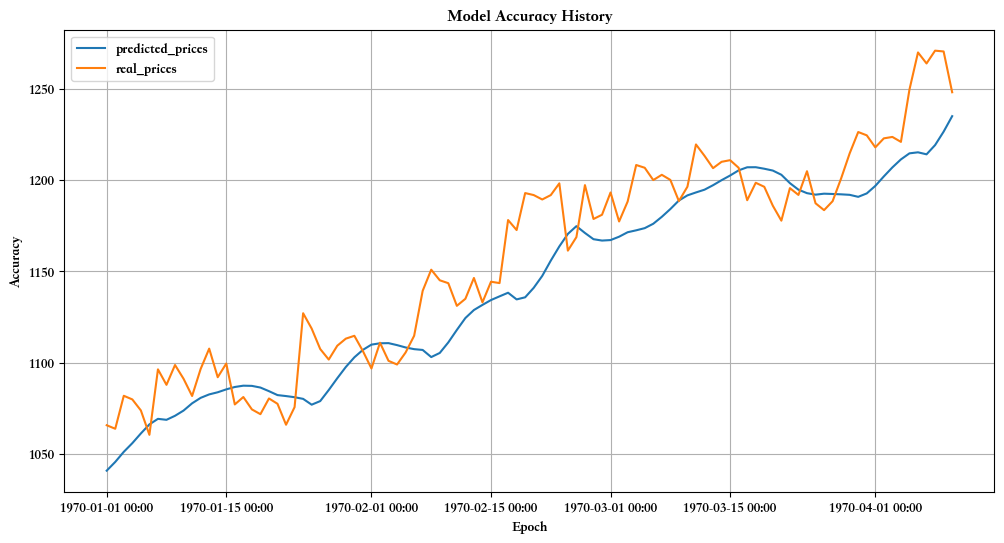

In [10]:
# 打印结果
fig, (ax) = plt.subplots(1,1,figsize=(12, 6))
plt.plot(predicted_prices, label='predicted_prices')
plt.plot(real_prices, label='real_prices')
plt.title('Model Accuracy History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
plt.grid(True)
fig.savefig(f'results/model_predicted_prices-{model_name}.png')
plt.show()

fig2, (ax2) = plt.subplots(1,1,figsize=(12, 6))
plt.plot(predicted_prices[-100:], label='predicted_prices')
plt.plot(real_prices[-100:], label='real_prices')
ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
plt.title('Model Accuracy History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
"""模型验证和评估"""
print("评估模型...")
mse = mean_squared_error(real_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_prices, predicted_prices)
r2 = r2_score(real_prices, predicted_prices)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

评估模型...
Mean Squared Error (MSE): 61.843401144248645
Root Mean Squared Error (RMSE): 7.864057549652638
Mean Absolute Error (MAE): 4.3204156786859516
R-squared (R2): 0.9973284449227914


/var/folders/5n/8x0dgwn903d3y5tfv1y93xj00000gn/T/ipykernel_80229/776426304.py:23: UserWarning: Glyph 8226 (\N{BULLET}) missing from font(s) Songti SC.
  fig2.savefig(f'results/model_loss-{model_name}.png')
/opt/anaconda3/envs/python312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8226 (\N{BULLET}) missing from font(s) Songti SC.
  fig.canvas.print_figure(bytes_io, **kw)


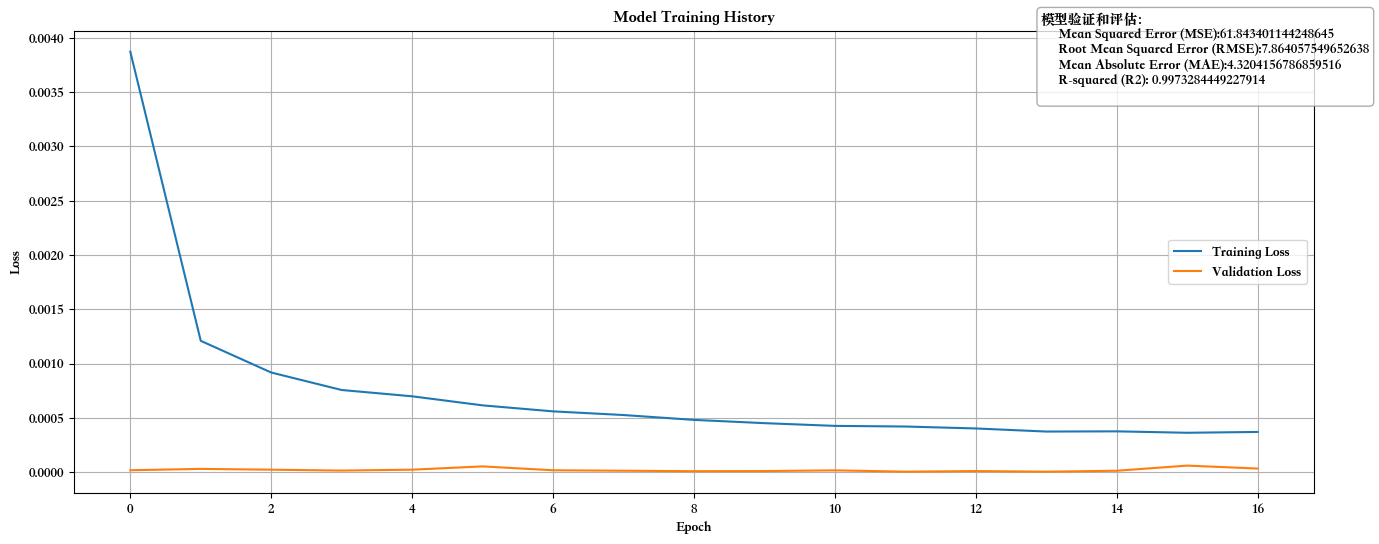

In [12]:
"""打印验证损失曲线"""
fig2 = plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'], label='Training Loss')
# 绘制验证损失曲线（如果有验证集）
plt.plot(history.history['val_loss'], label='Validation Loss')
# 添加统计信息框
stats_text = f"""模型验证和评估：
• Mean Squared Error (MSE):{mse}
• Root Mean Squared Error (RMSE):{rmse}
• Mean Absolute Error (MAE):{mae}
• R-squared (R2): {r2}
"""

plt.annotate(stats_text, 
            xy=(0.78, 0.85), 
            xycoords='axes fraction',
            bbox=dict(boxstyle="round", fc="white", ec="#999999", alpha=0.8))
plt.title(f'Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
fig2.savefig(f'results/model_loss-{model_name}.png')
plt.show()

1226/1226 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
原始y形状：(56042, 1)
序列y形状：(39212, 1)
ensemble特征形状：(39212, 722)
残差模型y形状：(39212, 1)
修正后 MSE: 61.1303 (改善 1.2%)
修正后 MAE: 4.2707 (改善 1.2%)


/var/folders/5n/8x0dgwn903d3y5tfv1y93xj00000gn/T/ipykernel_80229/1795075985.py:58: UserWarning: Glyph 8226 (\N{BULLET}) missing from font(s) Songti SC.
  fig4.savefig(f'results/evaluate_adjusted-{model_name}.png')
/opt/anaconda3/envs/python312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8226 (\N{BULLET}) missing from font(s) Songti SC.
  fig.canvas.print_figure(bytes_io, **kw)


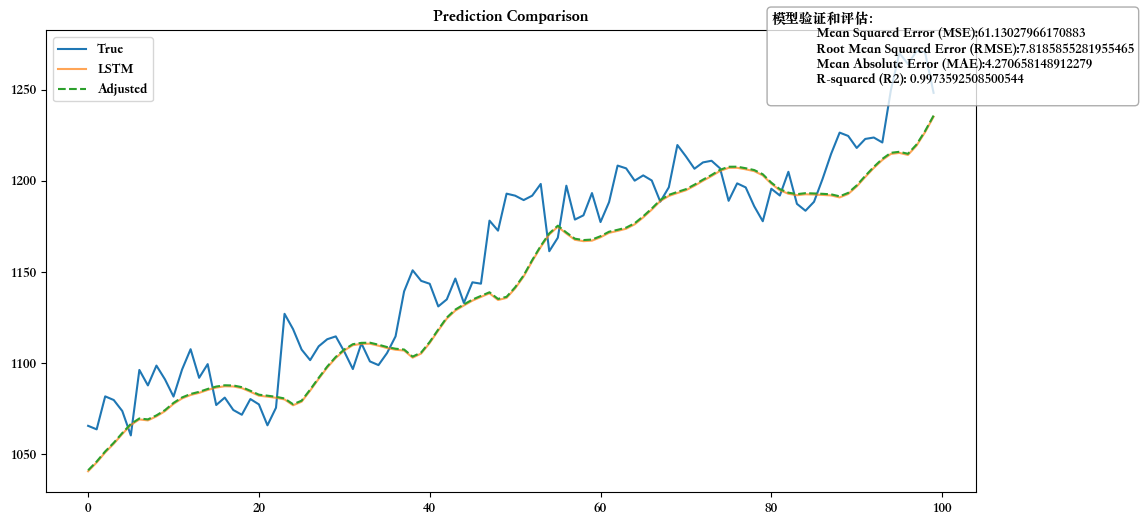

In [14]:
# 特征重构（加入时序特征）
def create_ensemble_features(X, predictions):
    return np.concatenate([
        X.reshape(X.shape[0], -1),          # 原始特征
        predictions.reshape(-1,1),                        # LSTM预测值
        np.arange(len(predictions))[:,None] # 时序位置特征
    ], axis=1)

# 训练残差修正模型
ensemble_train_features = create_ensemble_features(X_train, model.predict(X_train))

# 在数据预处理阶段
print(f"原始y形状：{y.shape}")  # 应为 (n_samples,)

# 在创建序列后
print(f"序列y形状：{y_train.shape}")  # 应为 (n_samples,)

# 在残差模型训练前
print(f"ensemble特征形状：{ensemble_train_features.shape}")
print(f"残差模型y形状：{y_train.shape}")
residual_model = GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.01,
    max_depth=3
)
residual_model.fit(ensemble_train_features, y_train.ravel())

# 组合预测
test_features = create_ensemble_features(X_test, predictions)
adjusted_predictions = predicted_prices.flatten() + residual_model.predict(test_features)

# 带残差修正的评估
def evaluate_adjusted():
    adj_mse = mean_squared_error(real_prices, adjusted_predictions)
    adj_rmse = np.sqrt(adj_mse)
    adj_mae = mean_absolute_error(real_prices, adjusted_predictions)
    adj_r2 = r2_score(real_prices, adjusted_predictions)
    print(f"修正后 MSE: {adj_mse:.4f} (改善 {100*(mse-adj_mse)/mse:.1f}%)")
    print(f"修正后 MAE: {adj_mae:.4f} (改善 {100*(mae-adj_mae)/mae:.1f}%)")

    fig4 = plt.figure(figsize=(12,6))
    plt.plot(real_prices[-100:], label='True')
    plt.plot(predicted_prices[-100:], label='LSTM', alpha=0.7)
    plt.plot(adjusted_predictions[-100:], label='Adjusted', linestyle='--')
    plt.title('Prediction Comparison')
    stats_text = f"""模型验证和评估：
        • Mean Squared Error (MSE):{adj_mse}
        • Root Mean Squared Error (RMSE):{adj_rmse}
        • Mean Absolute Error (MAE):{adj_mae}
        • R-squared (R2): {adj_r2}
        """

    plt.annotate(stats_text, 
                xy=(0.78, 0.85), 
                xycoords='axes fraction',
                bbox=dict(boxstyle="round", fc="white", ec="#999999", alpha=0.8))
    plt.legend()
    fig4.savefig(f'results/evaluate_adjusted-{model_name}.png')
    plt.show()

evaluate_adjusted()